In [1]:
EXPERIMENT_NAME = "Closed Loop WBG Anneal"
EXPERIMENT_DESCRIPTION = "Allow anneal temp, time to vary while co-optimizing PL Intenstiy, FWHM"

# Generate instructions for liquid handler, characterization

In [2]:
from frgpascal.experimentaldesign.helpers import export_closedloop
from frgpascal.experimentaldesign.tasks import *
from frgpascal.experimentaldesign.characterizationtasks import PLSpectroscopy, PLPhotostability,PLImaging, TransmissionSpectroscopy, Darkfield, Brightfield
from frgpascal.hardware.liquidlabware import TipRack, LiquidLabware, AVAILABLE_VERSIONS as liquid_labware_versions
from frgpascal.hardware.sampletray import SampleTray, AVAILABLE_VERSIONS as sampletray_versions



Define hardware on liquid handler. Tip racks only, to get the ot2 protocol

In [18]:
tray4ml = LiquidLabware(
    name='4mL_Tray1',
    version='frg_24_wellplate_4000ul',
    deck_slot=6
    )
plate96 = LiquidLabware(
    name="96wellplate",
    version="greiner_96_wellplate_360ul",
    deck_slot=5,
    starting_well="F1"
)
# tray15ml = LiquidLabware(
#     name="15mL_Tray1",
#     version="frg_12_wellplate_15000ul",
#     deck_slot=4
# )

tipracks = [
    TipRack(
        version='perkinelmer_p235_tiprack_235ul', 
        deck_slot=8,
        starting_tip="B11"
    ),
    TipRack(
        version='perkinelmer_p235_tiprack_235ul', 
        deck_slot=11,
        starting_tip="B5"
    ),
]

In [9]:
chartask = Characterize(
    tasks = [
        PLSpectroscopy(
            exposure_times = [1,5,10,30,60]
            ),
        TransmissionSpectroscopy(),
        PLPhotostability(
            exposure_time = 2,
            duration=60,
            jitter = 1
        ),
        Brightfield(),
        Darkfield(),
        PLImaging(),
    ],
    # reorder_by_position=True,
)

In [5]:
export_closedloop(
    name = EXPERIMENT_NAME,
    characterization_task= chartask,
    labware = [
        tray4ml,
        # tray15ml,
        plate96
    ],
    tipracks = tipracks,
)

OT2 protocol dumped to ".\OT2PASCALProtocol_Closed Loop WBG Anneal.py"
Closed Loop Maestro Netlist dumped to "maestronetlist_closedloop_Closed Loop WBG Anneal.json"


copy into cmdprmpt

In [ ]:
lh.server.ip = '169.254.160.20'
lh.server._start_directly()
mixing_netlist = {
   '4mL_Tray1-A2': {'96wellplate-F1': 35.0},
   '4mL_Tray1-A1': {'96wellplate-F1': 20.0}
}

lh.mix(mixing_netlist = mixing_netlist)

# Define Experiment

In [6]:
from ax import *
from frgpascal.closedloop.bridge import PASCALAxQueue, PASCALRunner

Search Space

In [7]:
search_space = SearchSpace(
    parameters = [
        ChoiceParameter(
            name="anneal_temperature", 
            values = [100, 110, 120],
            parameter_type=ParameterType.FLOAT, 
            is_ordered = True
        ),
        RangeParameter(
            name="anneal_duration",
            lower=60*10.0, #10 minutes
            upper = 60*90.0, #1.5 hrs
            parameter_type=ParameterType.FLOAT
        )
    ]
)

C:\Users\Admin\.conda\envs\pascal2\lib\site-packages\ax\core\parameter.py:467: UserWarning:

`sort_values` is not specified for `ChoiceParameter` "anneal_temperature". Defaulting to `True` for parameters of `ParameterType` FLOAT. To override this behavior (or avoid this warning), specify `sort_values` during `ChoiceParameter` construction.



Subclass `PASCALAxQueue` to fill in `initialize_labware` and `build_sample` methods.

In [8]:
from frgpascal.hardware.sampletray import Tray1, Tray2
import mixsol as mx

In [9]:
class ThisQueue(PASCALAxQueue):
    hotplate_temperatures = []
    metrics_to_watch = ['pl_fwhm_0', 'pl_intensity_0']
    metrics_to_ignore = []

    def initialize_labware(self):
        self.liquidlabware = [tray4ml]
        self.mixlabware = plate96
        self.sampletray = Tray1()

        self.solutions = {
            'MethylAcetate': Solution(
                solvent='MethylAcetate',
            ),
            'absorber1': Solution(
                    solutes= 'FA_Pb_I3',
                    solvent= 'DMF3_DMSO1',
                    molarity= 1.2,
                    alias="Absorber_1.09_PbX"
            ),
            'absorber2': Solution(
                    solutes= 'MA_Pb_Br3',
                    solvent= 'DMF3_DMSO1',
                    molarity= 1.2,
            )
        }

        tray4ml.load(self.solutions['absorber1'], "A1")
        tray4ml.load(self.solutions['absorber2'], "A2")
        tray4ml.load(self.solutions["MethylAcetate"], "D1")

        self.mixer = mx.Mixer(
            stock_solutions=list(self.solutions.values()),
        )
    def build_sample(self, parameters) -> Sample:
        soln = Solution(
            solutes = f'MA{parameters["MA"]}_FA{1-parameters["MA"]}_Pb_Br{3*parameters["MA"]}_I{3*(1-parameters["MA"])}',
            solvent="DMF3_DMSO1",
            molarity=1.2
        )
        
        mix_inputs = {
            soln: v
            for soln, v 
            in zip(
                self.mixer.solutions,
                self.mixer.mix(target=soln, volume=50, min_volume=0)
            )
        }

        destination_well = self.mixlabware.load(soln)
        mix = Mix(
            inputs=mix_inputs,
            inputs_labware=self.liquidlabware,
            destination_labware=self.mixlabware,
            destination_well=destination_well,
        )

        # spincoat_absorber = Spincoat(
        #     steps=[
        #         [1000,200,5], #speed (rpm), acceleration (rpm/s), duration (s)
        #         [5000,2000,50], #speed (rpm), acceleration (rpm/s), duration (s)
        #     ],
        #     drops = [
        #         Drop(
        #             solution=soln,  #this will be filled later using the list of psk solutions
        #             volume=20,
        #             time=-1,
        #             blow_out=True
        #         ),
        #         Drop(
        #             solution=self.solutions['MethylAcetate'],
        #             volume=50,
        #             time=33,
        #             reuse_tip=True,
        #             touch_tip=False,
        #             rate=100,
        #             pre_mix=(3,100),
        #             slow_travel=True,
        #             blow_out=False
        #         )
        #     ],
        #     # immediate=True
        # )
        # anneal_absorber = Anneal(
        #     temperature=parameters['anneal_temperature'],
        #     duration=parameters['anneal_duration'],
        # )

        samplename = f'sample{self.sample_counter}' #dont change
        sample = Sample(
            name = samplename, #dont change
            substrate='glass',
            worklist = [
                mix,
                # spincoat_absorber,
                # anneal_absorber,
                # Rest(),
                # chartask,
            ],
            storage_slot = {
                "tray": self.sampletray.name,  #dont change
                "slot": self.sampletray.load(samplename) #dont change
                },
        )
        return sample

In [10]:
jq = ThisQueue()

Note: attribute `hotplate_temperatures` was not defined, currently there are no temperatures/hotplates allocated for this experiment!


In [12]:
p = {"MA":0.8, "anneal_temperature":110, "anneal_duration":60*60}
jq.schedule_job_with_parameters(parameters=p)

Solving final schedule
	solution status: OPTIMAL


'sample1'

In [14]:
import matplotlib.pyplot as plt

120

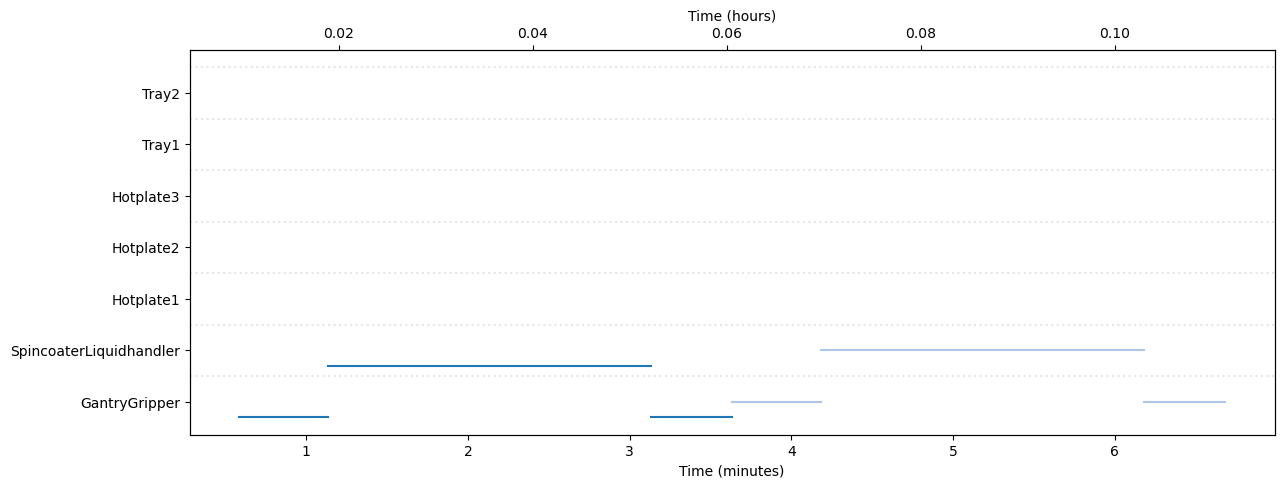

In [16]:
jq.system.scheduler.plot_solution()
plt.show()

In [21]:
td = jq.system.scheduler.protocols[1].worklist[1].to_dict()
td

{'name': 'mix',
 'start': 251,
 'id': 'mix-d7434ba3-7b2f-4dd4-b1f8-fd488bf52846',
 'details': {'mixing_netlist': {'4mL_Tray1-A2': {'96wellplate-F2': 40.0},
   '4mL_Tray1-A1': {'96wellplate-F2': 10.0}},
  'duration': 120},
 'sample': 'sample1',
 'precedent': 'storage_to_spincoater--76e0a4a0-99a4-4fc5-adc6-b7cc33c13563'}

In [22]:
mixing_netlist = td['details']['mixing_netlist']

In [23]:
ll = {
    l.name: l
    for l in jq.liquidlabware + [jq.mixlabware]
}

In [24]:
ll

{'4mL_Tray1': <LiquidLabware> 4mL_Tray1, 4.0 mL volume, 24 wells,
 '96wellplate': <LiquidLabware> 96wellplate, 0.36 mL volume, 96 wells}

In [27]:
for i, (source_str, destination_strings) in enumerate(mixing_netlist.items()):
    source_labware, source_well = source_str.split("-")
    source = ll[source_labware]

    destinations = []
    volumes = []
    for destination_str, volume in destination_strings.items():
        destination_labware, destination_well = destination_str.split("-")
        destinations.append(
            ll[destination_labware]
        )
        volumes.append(volume)
    print(source, destinations, volumes)

<LiquidLabware> 4mL_Tray1, 4.0 mL volume, 24 wells [<LiquidLabware> 96wellplate, 0.36 mL volume, 96 wells] [15.0]
<LiquidLabware> 4mL_Tray1, 4.0 mL volume, 24 wells [<LiquidLabware> 96wellplate, 0.36 mL volume, 96 wells] [35.0]


In [16]:
s.protocol

<Protocol> e5c62373-4abb-4351-aecc-fb4270cf318e
Worklist:
	<Transition: storage_to_spincoater, runs from 903 - 936>
	<Mix> 3 solutions into 96wellplate-E4
	<Spincoat>
	0-5.0s:	1000.0 rpm, 200 rpm/s
	5.0-55.0s:	5000.0 rpm, 2000 rpm/s
	<Drop> 20 uL of 1.2M MA0.7_FA0.3_Pb_Br2.1_I0.9 in DMF0.75_DMSO0.25 at -1s
	<Drop> 50 uL of MethylAcetate at 33s
	<Transition: spincoater_to_hotplate, runs from 1165 - 1192>
	<Anneal> 110C for 60.0 minutes
	<Transition: hotplate_to_storage, runs from 4792 - 4810>
	<Rest> 5.0 minutes
	<Transition: storage_to_characterization, runs from 5140 - 5155>
	<Characterize>
	PL_635nm
	Transmission
	Photostability_405nm
	Brightfield
	Darkfield
	PLImaging
	<Transition: characterization_to_storage, runs from 5421 - 5439>

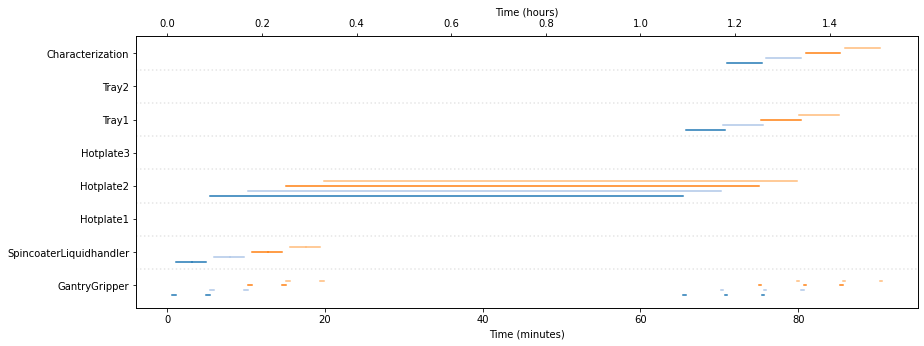

In [17]:
jq.system.scheduler.plot_solution()

Sample Generation Strategy

In [27]:
from ax.modelbridge.generation_strategy import GenerationStrategy, GenerationStep



NUM_SOBOL = 8
generation_strategy = GenerationStrategy(
    steps=[
        # 1. Initialization step (does not require pre-existing data and is well-suited for
        # initial sampling of the search space)
        GenerationStep(
            model=Models.SOBOL,
            num_trials=NUM_SOBOL,  # How many trials should be produced from this generation step
            min_trials_observed=5,  # How many trials need to be completed to move to next model
            max_parallelism=NUM_SOBOL,  # Max parallelism for this step
            model_kwargs={"seed": 999},  # Any kwargs you want passed into the model
            model_gen_kwargs={},  # Any kwargs you want passed to `modelbridge.gen`
        ),
        # 2. Bayesian optimization step (requires data obtained from previous phase and learns
        # from all data available at the time of each new candidate generation call)
        GenerationStep(
            model=Models.GPEI,
            num_trials=-1,  # No limitation on how many trials should be produced from this step
            max_parallelism=5,  # Parallelism limit for this step, often lower than for Sobol
            # More on parallelism vs. required samples in BayesOpt:
            # https://ax.dev/docs/bayesopt.html#tradeoff-between-parallelism-and-total-number-of-trials
        ),
    ]
)

----
# Begin the experiment!


Run `maestro.run_external(name, ot2_ip)` prior to proceeding

In [28]:
job_queue = ThisQueue() #dont change

Metric

In [29]:
from frgpascal.closedloop.metrics import BFInhomogeneity, DFMedian, PLFWHM, PLIntensity, PLPeak, PSIntensityScale

In [102]:
mo = MultiObjective(
    objectives=[
            Objective(PLIntensity(queue=job_queue)),
            Objective(PLFWHM(queue=job_queue)),
            ],
)
objective_thresholds = [
    ObjectiveThreshold(metric=metric, bound=val, relative=False)
    for metric, val in zip(mo.metrics, [0.4, 10])
]

optimization_config = MultiObjectiveOptimizationConfig(
    objective=mo,
    objective_thresholds=objective_thresholds,
)

In [103]:
optimization_config

MultiObjectiveOptimizationConfig(objective=MultiObjective(objectives=[Objective(metric_name="pl_intensity", minimize=False), Objective(metric_name="pl_fwhm", minimize=True)]), outcome_constraints=[], objective_thresholds=[ObjectiveThreshold(pl_intensity >= 0.4), ObjectiveThreshold(pl_fwhm <= 10)])

In [106]:
exp.immutable_search_space_and_opt_config 

AttributeError: can't set attribute

In [108]:
exp.optimization_config

MultiObjectiveOptimizationConfig(objective=MultiObjective(objectives=[Objective(metric_name="pl_fwhm", minimize=True), Objective(metric_name="pl_intensity", minimize=False)]), outcome_constraints=[], objective_thresholds=[ObjectiveThreshold(pl_fwhm <= 0.4), ObjectiveThreshold(pl_intensity >= 10)])

In [109]:
optimization_config

MultiObjectiveOptimizationConfig(objective=MultiObjective(objectives=[Objective(metric_name="pl_intensity", minimize=False), Objective(metric_name="pl_fwhm", minimize=True)]), outcome_constraints=[], objective_thresholds=[ObjectiveThreshold(pl_intensity >= 0.4), ObjectiveThreshold(pl_fwhm <= 10)])

Runner

In [31]:
job_runner = PASCALRunner(queue = job_queue)

Experiment

In [32]:
exp = Experiment(
    name = EXPERIMENT_NAME,
    description=EXPERIMENT_DESCRIPTION,
    search_space = search_space,
    optimization_config=optimization_config,
    runner=job_runner,
)

In [33]:
from ax.service.scheduler import Scheduler, SchedulerOptions
import logging

scheduler = Scheduler(
    experiment=exp,
    generation_strategy=generation_strategy,
    options=SchedulerOptions(
        log_filepath = os.path.join(job_queue.experiment_folder, 'ax_scheduler.log'),
        logging_level = logging.DEBUG,
        max_pending_trials=NUM_SOBOL,
        init_seconds_between_polls = 5,
        min_seconds_before_poll = 1,
        seconds_between_polls_backoff_factor=1
    ),
)

[INFO 04-05 14:58:19] Scheduler: `Scheduler` requires experiment to have immutable search space and optimization config. Setting property immutable_search_space_and_opt_config to `True` on experiment.


In [111]:
scheduler.generation_strategy = GenerationStrategy(
    steps=[
        GenerationStep(
            model=Models.MOO,
            num_trials=-1,  # No limitation on how many trials should be produced from this step
            max_parallelism=5,  # Parallelism limit for this step, often lower than for Sobol
            # More on parallelism vs. required samples in BayesOpt:
            # https://ax.dev/docs/bayesopt.html#tradeoff-between-parallelism-and-total-number-of-trials
        ),
    ]
)

## 5. Running the optimization

Once the `Scheduler` instance is set up, user can execute `run_n_trials` as many times as needed, and each execution will add up to the specified `max_trials` trials to the experiment. The number of trials actually run might be less than `max_trials` if the optimization was concluded (e.g. there are no more points in the search space).

In [112]:
exp.runner.poll_trial_status(exp.trials.values())

defaultdict(set, {<TrialStatus.COMPLETED: 3>: {0, 1, 2, 3, 4, 5, 6, 7}})

In [126]:
scheduler._

[DEBUG 04-05 17:18:32] ax.modelbridge.generation_strategy: Fitting model with data for trials: [0, 1, 3, 5, 7]


InputDataError: Input data contains NaN values.

In [117]:
scheduler.experiment.fetch_data().df

[INFO 04-05 17:16:21] ax.core.experiment: Attached data has some metrics ({'pl_fhwm'}) that are not among the metrics on this experiment. Note that attaching data will not automatically add those metrics to the experiment. For these metrics to be automatically fetched by `experiment.fetch_data`, add them via `experiment.add_tracking_metric` or update the experiment's optimization config.
[INFO 04-05 17:16:21] ax.core.experiment: Attached data has some metrics ({'pl_fhwm'}) that are not among the metrics on this experiment. Note that attaching data will not automatically add those metrics to the experiment. For these metrics to be automatically fetched by `experiment.fetch_data`, add them via `experiment.add_tracking_metric` or update the experiment's optimization config.
[INFO 04-05 17:16:21] ax.core.experiment: Attached data has some metrics ({'pl_fhwm'}) that are not among the metrics on this experiment. Note that attaching data will not automatically add those metrics to the experim

,arm_name,metric_name,mean,sem,trial_index
0,0_0,pl_intensity,118.940688,NaN,0
1,1_0,pl_intensity,43.518609,NaN,1
2,3_0,pl_intensity,37.917029,NaN,3
3,5_0,pl_intensity,11.843146,NaN,5
4,7_0,pl_intensity,24.789821,NaN,7


In [113]:
scheduler.run_n_trials(max_trials=25)

[DEBUG 04-05 17:14:03] ax.modelbridge.generation_strategy: Fitting model with data for trials: [0, 1, 3, 5, 7]


InputDataError: Input data contains NaN values.

In [64]:
for k, v in job_queue.jobs.items():
    if v.outcome != {}:
        print(k, v.outcome["pl_intensity_0"])

sample0 118.9406880198529
sample1 43.518609233238045
sample3 37.91702921573621
sample5 11.843145600217493
sample6 17.639083053066216
sample7 24.789821489308004


In [65]:
exp.metrics

{'pl_fwhm': PLFWHM('pl_fwhm'), 'pl_intensity': PLIntensity('pl_intensity')}

In [130]:
from ax.service.utils.report_utils import exp_to_df

exp_to_df(exp)

[INFO 04-05 17:24:00] ax.core.experiment: Attached data has some metrics ({'pl_fhwm'}) that are not among the metrics on this experiment. Note that attaching data will not automatically add those metrics to the experiment. For these metrics to be automatically fetched by `experiment.fetch_data`, add them via `experiment.add_tracking_metric` or update the experiment's optimization config.
[INFO 04-05 17:24:00] ax.core.experiment: Attached data has some metrics ({'pl_fhwm'}) that are not among the metrics on this experiment. Note that attaching data will not automatically add those metrics to the experiment. For these metrics to be automatically fetched by `experiment.fetch_data`, add them via `experiment.add_tracking_metric` or update the experiment's optimization config.
[INFO 04-05 17:24:00] ax.core.experiment: Attached data has some metrics ({'pl_fhwm'}) that are not among the metrics on this experiment. Note that attaching data will not automatically add those metrics to the experim

,pl_intensity,trial_index,arm_name,anneal_temperature,anneal_duration,trial_status,generation_method
0,118.940688,0,0_0,110.0,3071.089268,COMPLETED,Sobol
1,43.518609,1,1_0,110.0,2502.075899,COMPLETED,Sobol
5,NaN,2,2_0,100.0,5087.644941,RUNNING,Sobol
2,37.917029,3,3_0,120.0,786.069569,COMPLETED,Sobol
6,NaN,4,4_0,120.0,4479.535103,RUNNING,Sobol
3,11.843146,5,5_0,100.0,1356.125370,COMPLETED,Sobol
7,NaN,6,6_0,100.0,3646.088621,RUNNING,Sobol
4,24.789821,7,7_0,110.0,1890.121311,COMPLETED,Sobol


In [127]:
data = exp.fetch_data()

[INFO 04-05 17:19:52] ax.core.experiment: Attached data has some metrics ({'pl_fhwm'}) that are not among the metrics on this experiment. Note that attaching data will not automatically add those metrics to the experiment. For these metrics to be automatically fetched by `experiment.fetch_data`, add them via `experiment.add_tracking_metric` or update the experiment's optimization config.
[INFO 04-05 17:19:52] ax.core.experiment: Attached data has some metrics ({'pl_fhwm'}) that are not among the metrics on this experiment. Note that attaching data will not automatically add those metrics to the experiment. For these metrics to be automatically fetched by `experiment.fetch_data`, add them via `experiment.add_tracking_metric` or update the experiment's optimization config.
[INFO 04-05 17:19:52] ax.core.experiment: Attached data has some metrics ({'pl_fhwm'}) that are not among the metrics on this experiment. Note that attaching data will not automatically add those metrics to the experim

Save results alone

In [ ]:
from ax.service.utils.report_utils import exp_to_df

df = exp_to_df(exp)
df.to_csv(os.path.join(job_queue.experiment_folder, f'{EXPERIMENT_NAME}_closedloop_results.csv'))